In [ ]:
%%capture
!pip install pandas==1.1.5
!pip install wget==3.2
!pip install fasttext==0.9.2

In [ ]:
%%capture
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_md

In [ ]:
%%capture
!pip install spacy==2.2.4

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
import re
import pandas as pd
import operator
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
# import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
EMOJI_MAP = {
    'admiration': '👏',
    'amusement': '😂',
    'anger': '😡',
    'annoyance': '😒',
    'approval': '👍',
    'caring': '🤗',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😍',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤮',
    'embarrassment': '😳',
    'excitement': '🤩',
    'fear': '😨',
    'gratitude': '🙏',
    'grief': '😢',
    'joy': '😃',
    'love': '❤️',
    'nervousness': '😬',
    'optimism': '🤞',
    'pride': '😌',
    'realization': '💡',
    'relief': '😅',
    'remorse': '',
    'sadness': '😞',
    'surprise': '😲',
    'neutral': '',
}

# Загрузка данных

In [ ]:
df_mix = pd.read_csv('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv', sep='\t', header=None, names=['text', 'label', 'id'])
df_mix[df_mix['label'].str.contains(',')]

,text,label,id
7,We need more boards and to create a bit more s...,"8,20",ef4qmod
11,"Aww... she'll probably come around eventually,...","1,4",edex4ki
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12",edivtm3
19,Maybe that’s what happened to the great white ...,"6,22",eczq8zg
20,"I never thought it was at the same moment, but...","6,9,27",efdlhs1
...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27",ef2m53x
43383,it's horrid :/,"14,27",edlbr3j
43388,Fuck these trendy hipster joints. Give me my s...,"2,3",ee3nyiy
43395,Sorry I kind of took it like you were flexing ...,"1,24",eelhhzc


Видим, что некоторые твиты содержат сразу несколько классов смайлов.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv', sep='\t', header=None, names=['text', 'label', 'id'])
df.drop(['id'], axis=1, inplace=True)
df = df[~df['label'].str.contains(',')]

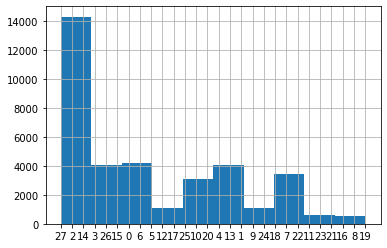

In [ ]:
df['label'].hist()

При этом классы не сбалансированы. Наибольшее кол-во твитов не содержат какие-либо смайлы и носят нейтральную окраску. Поэтому возникла идея в твитах, где содержатся сразу несколько классов смайлов, оставить один класс смайла, который яв-ся самым малочисленным из представленных.

In [ ]:
df_mix = pd.read_csv('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv', sep='\t', header=None, names=['text', 'label', 'id'])
df_mix = df_mix[df_mix['label'].str.contains(',')]

In [ ]:
def new_label(data_mix, data):
  label_list = []
  for label in data_mix.label:
    label_list.append(label.split(','))
  new_list = list()
  for lbl_list in label_list:
    lbl_dict = dict()
    for lbl in lbl_list:
      lbl_dict[lbl] = data.label.value_counts()[lbl]
    new_list.append(lbl_dict)
  new_label = []
  for every_dict in new_list:
    sorted_x = sorted(every_dict.items(), key=operator.itemgetter(1))
    new_label.append(sorted_x[:1][0][0])
  return new_label

In [ ]:
df_mix['label'] = new_label(df_mix, df)
df_mix.drop(['id'], axis=1, inplace=True)
data = pd.concat([df, df_mix])

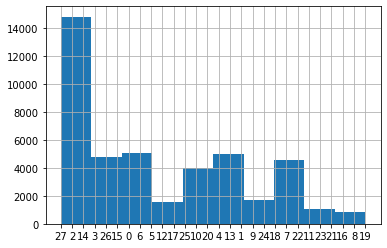

In [ ]:
data['label'].hist()

In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv', sep='\t', header=None, names=['text', 'label', 'id'])
test_mix = test[test['label'].str.contains(',')]
test.drop(['id'], axis=1, inplace=True)
test = test[~test['label'].str.contains(',')]

In [ ]:
test_mix['label'] = new_label(test_mix, test)
test_mix.drop(['id'], axis=1, inplace=True)
test = pd.concat([test, test_mix])

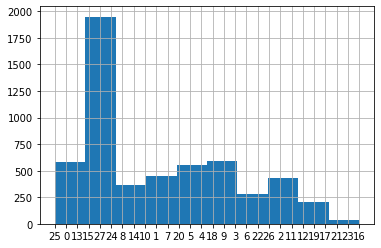

In [ ]:
test['label'].hist()

In [ ]:
data.label = data.label.apply(lambda x: int(x))
test.label = test.label.apply(lambda x: int(x))

In [ ]:
data_vis = data.copy()

In [ ]:
data_vis['emoji'] = data['label'].apply(lambda x:EMOJI_MAP[list(EMOJI_MAP.keys())[int(x)]])

In [ ]:
data_vis['emoji_text'] = data['label'].apply(lambda x:list(EMOJI_MAP.keys())[int(x)])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


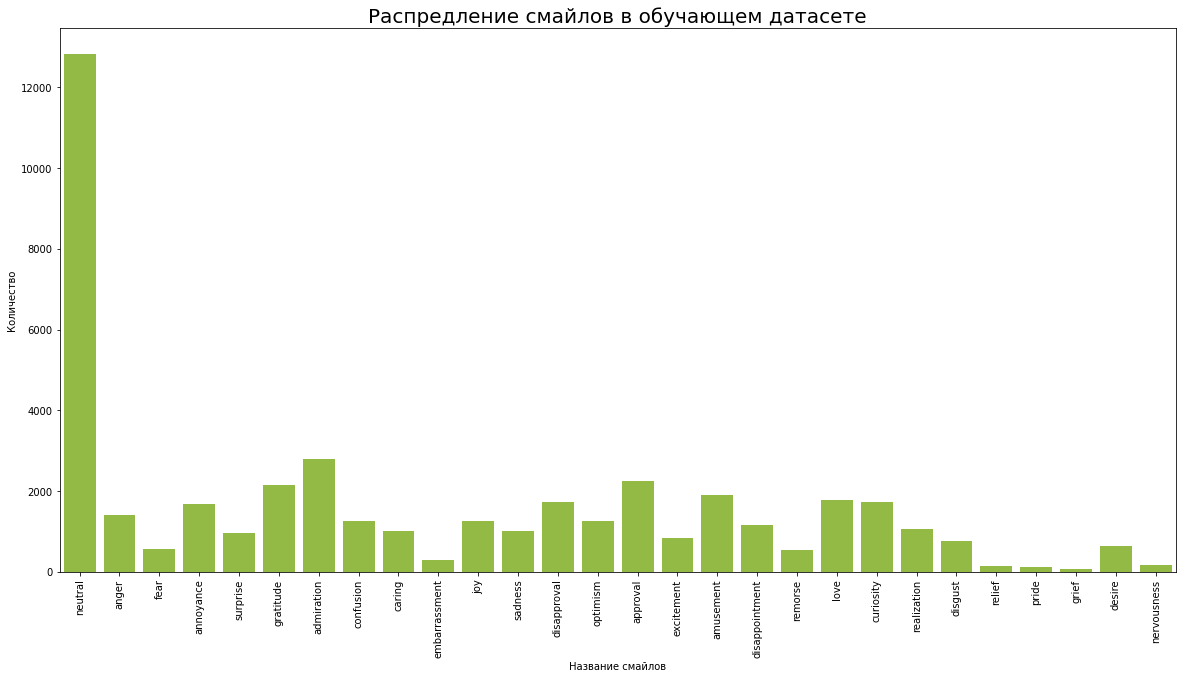

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.countplot(data_vis.emoji_text, color = 'yellowgreen')
plt.xticks(rotation='vertical')
plt.title('Распредление смайлов в обучающем датасете', fontsize=20)
plt.ylabel('Количество')
plt.xlabel('Название смайлов')
plt.savefig('emoji_distriburion.png')

# Обработка текста

In [ ]:
data = data[data['text'] != '']

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def clean_text(text):

  RE_ASCII = re.compile(r"[^A-Za-z]", re.IGNORECASE)
  RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
  
  text = re.sub(RE_ASCII, " ", text)
  text = re.sub(RE_WSPACE, " ", text)
  # Удаление одних и тех же символов, повторяющихся друг за другом более 2 раз
  text = re.sub(r'([a-z])\1+', r'\1\1', text)
  # Удаление одиночных символов
  text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

  word_tokens = word_tokenize(text)
  words_tokens_lower = [word.lower() for word in word_tokens if word not in stop_words]
  text_clean = " ".join(words_tokens_lower)
  return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['text'] = data['text'].map(lambda x:clean_text(x))

In [ ]:
data['text_lemma'] = data['text'].map(lambda x:" ".join([token.lemma_ for token in nlp(x)]))

In [ ]:
test['text'] = test['text'].map(lambda x:clean_text(x))

In [ ]:
test['text_lemma'] = test['text'].map(lambda x:" ".join([token.lemma_ for token in nlp(x)]))

In [ ]:
data.text_lemma = data.text_lemma.apply(lambda x: re.sub(r'([a-z])\1+', r'\1\1', x))

In [ ]:
test.text_lemma = test.text_lemma.apply(lambda x: re.sub(r'([a-z])\1+', r'\1\1', x))

# Обучающая и тестовая выборка

In [ ]:
x_train = data['text_lemma'].values
x_test = test['text_lemma'].values

In [ ]:
y_train = data.label.values
y_test = test.label.values

# Tf-Idf, Random Forest

In [ ]:
model_tfidf = TfidfVectorizer()

train_tfidf = model_tfidf.fit_transform(x_train)
test_tfidf = model_tfidf.transform(x_test)

In [ ]:
cls = RandomForestClassifier(random_state=42)
cls.fit(train_tfidf, y_train)

predictions = cls.predict(test_tfidf)

In [ ]:
f1_score(predictions, y_test, average = 'weighted')

0.5612520210578145

In [ ]:
print(classification_report(predictions, y_test, target_names = list(EMOJI_MAP.keys())))

                precision    recall  f1-score   support

    admiration       0.55      0.51      0.53       387
     amusement       0.74      0.67      0.70       243
         anger       0.34      0.44      0.39       141
     annoyance       0.04      0.37      0.08        27
      approval       0.12      0.37      0.19        94
        caring       0.15      0.42      0.22        45
     confusion       0.07      0.42      0.12        24
     curiosity       0.12      0.40      0.18        65
        desire       0.20      0.50      0.28        32
disappointment       0.09      0.43      0.14        28
   disapproval       0.04      0.31      0.07        29
       disgust       0.25      0.61      0.36        49
 embarrassment       0.14      0.38      0.20        13
    excitement       0.20      0.43      0.27        47
          fear       0.51      0.63      0.56        60
     gratitude       0.87      0.80      0.84       312
         grief       0.00      0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
n_estimators_arr = [100, 200]
f1_score_arr = [0.5665, 0.5648]
pd.DataFrame({'Количество деревьев':n_estimators_arr, 'F1-score':f1_score_arr}).sort_values(by = 'F1-score', ascending=False)

,Количество деревьев,F1-score
0,100,0.5665
1,200,0.5648


# FastText

In [ ]:
label_prefix='__class__'
data['class'] = label_prefix + data['label'].astype(str) + ' '
data.to_csv('train.csv', \
            header=None,\
                  index=False, columns=['class', 'text_lemma'])

In [ ]:
test['class'] = label_prefix + test['label'].astype(str) + ' '
test.to_csv('test.csv', \
            header=None,\
                  index=False, columns=['class', 'text_lemma'])

In [ ]:
%%time

from fasttext import train_supervised 
train_file = '/content/train.csv'
model = train_supervised(input=train_file, label="__class__")

CPU times: user 2.69 s, sys: 134 ms, total: 2.83 s
Wall time: 2.83 s


In [ ]:
test_file = '/content/test.csv'
f1_score = []
for k in range(1,6):
    results = model.test(test_file,k=k)
    f1_score.append(2*(results[1]*100 * results[2]*100)/(results[1]*100 + results[2]*100))
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")
print(np.mean(np.array(f1_score)))

Test Samples: 5427 Precision@1 : 36.1526 Recall@1 : 36.1526
Test Samples: 5427 Precision@2 : 24.4334 Recall@2 : 48.8668
Test Samples: 5427 Precision@3 : 19.0160 Recall@3 : 57.0481
Test Samples: 5427 Precision@4 : 15.7592 Recall@4 : 63.0367
Test Samples: 5427 Precision@5 : 13.5839 Recall@5 : 67.9197
29.021804557459614


# LSTM

In [ ]:
VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data.text_lemma.values)

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE) 
tokenizer.fit_on_texts(data.text.values) 
train_sequences = tokenizer.texts_to_sequences(data.text_lemma.values) 
test_sequences = tokenizer.texts_to_sequences(test.text_lemma.values) 
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 25480 unique tokens.


In [ ]:
allreviews = np.concatenate((train_sequences, test_sequences), axis=0)

print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

Maximum review length: 26
Minimum review length: 0
Mean review length: 6.451809079181768


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
review_length = 30

x_train_seq = sequence.pad_sequences(train_sequences, maxlen = review_length, padding='pre')
x_test_seq = sequence.pad_sequences(test_sequences, maxlen = review_length, padding='pre')

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE, 
        output_dim = 128,
        input_length = review_length
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.LSTM(
        units=32
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.Dense(
        units=28, 
        activation='softmax'
    )
)

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tfa.metrics.F1Score(average='weighted',num_classes=28)])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 128)           640000    
                                                                 
 dropout_12 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 28)                924       
                                                                 
Total params: 661,532
Trainable params: 661,532
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train_seq, y_train_cat,                   
    batch_size=32, 
    epochs=10, 
    validation_split=0.2,    
    verbose=1)

Epoch 1/10
1086/1086 [==============================] - 28s 24ms/step - loss: 2.2752 - f1_score: 0.3284 - val_loss: 3.0852 - val_f1_score: 0.1378
Epoch 2/10
1086/1086 [==============================] - 25s 23ms/step - loss: 1.7914 - f1_score: 0.4545 - val_loss: 2.9485 - val_f1_score: 0.1921
Epoch 3/10
1086/1086 [==============================] - 27s 25ms/step - loss: 1.6112 - f1_score: 0.5076 - val_loss: 2.8643 - val_f1_score: 0.2151
Epoch 4/10
1086/1086 [==============================] - 25s 23ms/step - loss: 1.5020 - f1_score: 0.5373 - val_loss: 2.9259 - val_f1_score: 0.2318
Epoch 5/10
1086/1086 [==============================] - 25s 23ms/step - loss: 1.4174 - f1_score: 0.5629 - val_loss: 2.9792 - val_f1_score: 0.2385
Epoch 6/10
1086/1086 [==============================] - 26s 24ms/step - loss: 1.3553 - f1_score: 0.5849 - val_loss: 3.0792 - val_f1_score: 0.2386
Epoch 7/10
1086/1086 [==============================] - 25s 23ms/step - loss: 1.2961 - f1_score: 0.6019 - val_loss: 3.1196 -

In [ ]:
model.evaluate(x_test_seq, y_test_cat)

170/170 [==============================] - 1s 6ms/step - loss: 2.0795 - f1_score: 0.4586


[2.079493761062622, 0.4586155116558075]

In [ ]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE, 
        output_dim = 256,
        input_length = review_length
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.LSTM(
        units=32
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.Dense(
        units=28, 
        activation='softmax'
    )
)

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tfa.metrics.F1Score(average='weighted',num_classes=28)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 26, 256)           1280000   
                                                                 
 dropout_6 (Dropout)         (None, 26, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                36992     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 28)                924       
                                                                 
Total params: 1,317,916
Trainable params: 1,317,916
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train_seq, y_train_cat,                   
    batch_size=32, 
    epochs=10, 
    validation_split=0.2,    
    verbose=1)

Epoch 1/10
1086/1086 [==============================] - 60s 52ms/step - loss: 2.1991 - f1_score: 0.3534 - val_loss: 2.9696 - val_f1_score: 0.1658
Epoch 2/10
1086/1086 [==============================] - 53s 48ms/step - loss: 1.7055 - f1_score: 0.4836 - val_loss: 2.8619 - val_f1_score: 0.2078
Epoch 3/10
1086/1086 [==============================] - 53s 49ms/step - loss: 1.5282 - f1_score: 0.5324 - val_loss: 2.9424 - val_f1_score: 0.2258
Epoch 4/10
1086/1086 [==============================] - 55s 51ms/step - loss: 1.4077 - f1_score: 0.5688 - val_loss: 2.9825 - val_f1_score: 0.2374
Epoch 5/10
1086/1086 [==============================] - 53s 49ms/step - loss: 1.3152 - f1_score: 0.5970 - val_loss: 3.0561 - val_f1_score: 0.2423
Epoch 6/10
1086/1086 [==============================] - 52s 48ms/step - loss: 1.2429 - f1_score: 0.6175 - val_loss: 3.0718 - val_f1_score: 0.2486
Epoch 7/10
1086/1086 [==============================] - 55s 51ms/step - loss: 1.1833 - f1_score: 0.6372 - val_loss: 3.2101 -

In [ ]:
model.evaluate(x_test_seq, y_test_cat)

170/170 [==============================] - 3s 15ms/step - loss: 2.1994 - f1_score: 0.4538


[2.1993885040283203, 0.4537808895111084]

In [ ]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = VOCAB_SIZE, 
        output_dim = 128,
        input_length = review_length
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.LSTM(
        units=64
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25
    )
)

model.add(
    tf.keras.layers.Dense(
        units=28, 
        activation='softmax'
    )
)

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tfa.metrics.F1Score(average='weighted',num_classes=28)])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 26, 128)           640000    
                                                                 
 dropout_10 (Dropout)        (None, 26, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 28)                1820      
                                                                 
Total params: 691,228
Trainable params: 691,228
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train_seq, y_train_cat,                   
    batch_size=32, 
    epochs=10, 
    validation_split=0.2,    
    verbose=1)

Epoch 1/10
1086/1086 [==============================] - 45s 39ms/step - loss: 2.1792 - f1_score: 0.3559 - val_loss: 3.0282 - val_f1_score: 0.1692
Epoch 2/10
1086/1086 [==============================] - 40s 37ms/step - loss: 1.6773 - f1_score: 0.4888 - val_loss: 2.9028 - val_f1_score: 0.2138
Epoch 3/10
1086/1086 [==============================] - 39s 36ms/step - loss: 1.4910 - f1_score: 0.5412 - val_loss: 2.9060 - val_f1_score: 0.2377
Epoch 4/10
1086/1086 [==============================] - 39s 36ms/step - loss: 1.3718 - f1_score: 0.5748 - val_loss: 2.9395 - val_f1_score: 0.2546
Epoch 5/10
1086/1086 [==============================] - 42s 39ms/step - loss: 1.2809 - f1_score: 0.6050 - val_loss: 3.1232 - val_f1_score: 0.2538
Epoch 6/10
1086/1086 [==============================] - 40s 37ms/step - loss: 1.2021 - f1_score: 0.6266 - val_loss: 3.1655 - val_f1_score: 0.2534
Epoch 7/10
1086/1086 [==============================] - 39s 36ms/step - loss: 1.1361 - f1_score: 0.6471 - val_loss: 3.2054 -

In [ ]:
model.evaluate(x_test_seq, y_test_cat)

170/170 [==============================] - 1s 8ms/step - loss: 2.1947 - f1_score: 0.4575


[2.1946871280670166, 0.4574846923351288]

In [ ]:
embedding_arr = [128, 256, 128, 128, 128, 128, 128, 128]
dropout_arr = [0.25, 0.25, 0.25, 0.25, 0.3, 0.3, 0.25, 0.25]
lstm_arr = [32, 32, 64, 32, 32, 32, 32, 32] 
batch_size_arr = [32, 32, 32, 32, 32, 32, 16, 2]
epoch_arr = [10, 10, 10, 20, 10, 10, 10, 10]
vocab_size_arr = [5000, 5000, 5000, 10000, 20000, 5000, 5000, 5000]
f1_score_arr = [0.53, 0.4538, 0.5, 0.5, 0.5, 0.5, 0.5, 0.52]
pd.DataFrame({'Размер эмбеддинга':embedding_arr, 'Размер дропаута':dropout_arr,\
              'Размер LSTM':lstm_arr, 'Размер батча': batch_size_arr, \
              'Количество эпох': epoch_arr, 'Размер словаря':vocab_size_arr,\
              'F1-score':f1_score_arr}).sort_values(by = 'F1-score', ascending=False)

,Размер эмбеддинга,Размер дропаута,Размер LSTM,Размер батча,Количество эпох,Размер словаря,F1-score
0,128,0.25,32,32,10,5000,0.5300
7,128,0.25,32,2,10,5000,0.5200
2,128,0.25,64,32,10,5000,0.5000
3,128,0.25,32,32,20,10000,0.5000
4,128,0.30,32,32,10,20000,0.5000
5,128,0.30,32,32,10,5000,0.5000
6,128,0.25,32,16,10,5000,0.5000
1,256,0.25,32,32,10,5000,0.4538


In [ ]:
predicted = model.predict(x_test_seq)

170/170 [==============================] - 1s 6ms/step


In [ ]:
print(classification_report(np.argmax(predicted, axis=1), np.argmax(y_test_cat, axis=1), target_names = list(EMOJI_MAP.keys())))

                precision    recall  f1-score   support

    admiration       0.62      0.48      0.54       464
     amusement       0.75      0.62      0.68       269
         anger       0.30      0.43      0.35       129
     annoyance       0.19      0.28      0.23       163
      approval       0.18      0.30      0.23       168
        caring       0.19      0.40      0.26        62
     confusion       0.12      0.21      0.15        81
     curiosity       0.16      0.33      0.22       108
        desire       0.24      0.35      0.29        57
disappointment       0.12      0.35      0.18        48
   disapproval       0.09      0.25      0.14        79
       disgust       0.31      0.58      0.40        64
 embarrassment       0.22      0.44      0.29        18
    excitement       0.17      0.52      0.26        33
          fear       0.52      0.66      0.58        59
     gratitude       0.89      0.77      0.83       331
         grief       0.00      0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

In [ ]:
!pip install transformers==4.5.1
!pip install torch==1.8.1
!pip install sentencepiece==0.1.95
!pip install pandas==1.1.5
!pip install numpy==1.19.5
!pip install scikit-learn==0.22.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 10.7 MB/s 
     |████████████████████████████████| 880 kB 55.5 MB/s 
     |████████████████████████████████| 3.3 MB 47.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a99dde7e2ccac47f7e29edf88a233d2ef93a471cab800c2f17452a8bb661cacd
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 15.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.2 which is incompatible.
kapre 0.3.7 requires tensorflow>

In [ ]:
import torch
from torch.utils.data import Dataset

class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=1):
        # print('*' * 10)
        # print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
        # print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

import pandas as pd

train = data.iloc[int(data.shape[0]*0.1):]
valid = data.iloc[:int(data.shape[0]*0.1)]
test = test

classifier = BertClassifier(
    path="cointegrated/rubert-tiny",
    n_classes=28
)

classifier.train(
        X_train=list(train['text_lemma']),
        y_train=list(train['label']),
        X_valid=list(valid['text_lemma']),
        y_valid=list(valid['label']),
        X_test=list(test['text_lemma']),
        y_test=list(test['label']),
        epochs=5
)

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Epoch 1/5


100%|██████████| 19535/19535 [07:15<00:00, 44.82it/s]


Train loss 2.095660560159716 accuracy 0.4572423148788042


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.420540481729161, recall: 0.3615672270796059, f1score: 0.3533856888883826


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4184058472063007, recall: 0.3453226286123937, f1score: 0.3402881710703111
Epoch 2/5


100%|██████████| 19535/19535 [07:14<00:00, 44.98it/s]


Train loss 1.7992551423320349 accuracy 0.519388773708055


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.44692719970269, recall: 0.4103107383705587, f1score: 0.40517801278081617


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.47589691314711813, recall: 0.38678532405969884, f1score: 0.4018495541571795
Epoch 3/5


100%|██████████| 19535/19535 [07:13<00:00, 45.11it/s]


Train loss 1.7005740018503082 accuracy 0.5415802810412348


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4568745766685184, recall: 0.4240124473051103, f1score: 0.4232086304727732


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.47400772136061703, recall: 0.3900199180712866, f1score: 0.40543617393269543
Epoch 4/5


100%|██████████| 19535/19535 [07:13<00:00, 45.06it/s]


Train loss 1.632670582805543 accuracy 0.5580895339015588


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4436108790597361, recall: 0.4298523136490731, f1score: 0.4232117933763578


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4655635832020923, recall: 0.3966797684134153, f1score: 0.4105670128636237
Epoch 5/5


100%|██████████| 19535/19535 [07:13<00:00, 45.06it/s]


Train loss 1.578955137713078 accuracy 0.5726023189741227


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4280679543498227, recall: 0.4393920045120616, f1score: 0.4234716231616133
Test:
precision: 0.46219845034833773, recall: 0.40886391446819786, f1score: 0.41885007236795174


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [ ]:
import torch
from torch.utils.data import Dataset

class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=16, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-7,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=1):
        # print('*' * 10)
        # print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
        # print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

import pandas as pd

train = data.iloc[int(data.shape[0]*0.1):]
valid = data.iloc[:int(data.shape[0]*0.1)]
test = test

classifier = BertClassifier(
    path="cointegrated/rubert-tiny",
    n_classes=28
)

classifier.train(
        X_train=list(train['text_lemma']),
        y_train=list(train['label']),
        X_valid=list(valid['text_lemma']),
        y_valid=list(valid['label']),
        X_test=list(test['text_lemma']),
        y_test=list(test['label']),
        epochs=5
)

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Epoch 1/5


100%|██████████| 2442/2442 [05:16<00:00,  7.72it/s]


Train loss 3.275870934263006 accuracy 0.12452327932632011


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.01881570486170422, recall: 0.03632732865345963, f1score: 0.023634866172398294


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.021643359536949132, recall: 0.036447909471168924, f1score: 0.02169427887579367
Epoch 2/5


100%|██████████| 2442/2442 [05:16<00:00,  7.72it/s]


Train loss 3.178819596913874 accuracy 0.2761524482326141


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.01284858262272413, recall: 0.03571428571428571, f1score: 0.018898305084745763


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.010570796693170448, recall: 0.03571428571428571, f1score: 0.016313180562327317
Epoch 3/5


100%|██████████| 2442/2442 [05:15<00:00,  7.75it/s]


Train loss 3.0981322905745885 accuracy 0.28795208477309375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.012842662980879981, recall: 0.03571428571428571, f1score: 0.01889190105049136


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.010568848877306589, recall: 0.03571428571428571, f1score: 0.01631086104283886
Epoch 4/5


100%|██████████| 2442/2442 [05:23<00:00,  7.54it/s]


Train loss 3.0430556774920463 accuracy 0.28823363792264967


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.012842662980879981, recall: 0.03571428571428571, f1score: 0.01889190105049136


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.010568848877306589, recall: 0.03571428571428571, f1score: 0.01631086104283886
Epoch 5/5


100%|██████████| 2442/2442 [05:31<00:00,  7.38it/s]


Train loss 3.016507232608998 accuracy 0.2882592336635184


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.012842662980879981, recall: 0.03571428571428571, f1score: 0.01889190105049136
Test:
precision: 0.010568848877306589, recall: 0.03571428571428571, f1score: 0.01631086104283886


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [ ]:
import torch
from torch.utils.data import Dataset

class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=1):
        # print('*' * 10)
        # print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
        # print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

import pandas as pd

train = data.iloc[int(data.shape[0]*0.1):]
valid = data.iloc[:int(data.shape[0]*0.1)]
test = test

classifier = BertClassifier(
    path="cointegrated/rubert-tiny",
    n_classes=28
)

classifier.train(
        X_train=list(train['text_lemma']),
        y_train=list(train['label']),
        X_valid=list(valid['text_lemma']),
        y_valid=list(valid['label']),
        X_test=list(test['text_lemma']),
        y_test=list(test['label']),
        epochs=10
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Epoch 1/10


100%|██████████| 19535/19535 [09:11<00:00, 35.41it/s]


Train loss 2.086783755590006 accuracy 0.45783101691878475


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.465371980980201, recall: 0.36397482966179806, f1score: 0.3719585965968038


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.43368291781918994, recall: 0.32782975953600785, f1score: 0.33125543366184856
Epoch 2/10


100%|██████████| 19535/19535 [08:34<00:00, 37.98it/s]


Train loss 1.7905234561524646 accuracy 0.5204381990836725


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.45488513886933823, recall: 0.42152732170744234, f1score: 0.41523361965032296


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4702400421086579, recall: 0.38929826008598045, f1score: 0.4010437020900161
Epoch 3/10


100%|██████████| 19535/19535 [09:21<00:00, 34.79it/s]


Train loss 1.6914474348881356 accuracy 0.5416058767821035


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4396700217935431, recall: 0.4433078569194068, f1score: 0.4304825773082743


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4640624789404086, recall: 0.4127457757937697, f1score: 0.4243766861277716
Epoch 4/10


100%|██████████| 19535/19535 [07:37<00:00, 42.67it/s]


Train loss 1.6166906320996366 accuracy 0.5627735544805345


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4379972473061278, recall: 0.4427673870874243, f1score: 0.42934336253260225


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4652352810531007, recall: 0.41427685776817136, f1score: 0.4274709706118373
Epoch 5/10


100%|██████████| 19535/19535 [08:19<00:00, 39.09it/s]


Train loss 1.5430150168172092 accuracy 0.5827894238398731


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.43539840471866903, recall: 0.4600918937846384, f1score: 0.4383667377611629


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.45641293879660666, recall: 0.42226466796996387, f1score: 0.42946594624030354
Epoch 6/10


100%|██████████| 19535/19535 [07:30<00:00, 43.38it/s]


Train loss 1.4842687664035659 accuracy 0.6009879955975326


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.43375840224061957, recall: 0.463384161782996, f1score: 0.4396434114834232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4453228018533308, recall: 0.4184561949776979, f1score: 0.42324440315925443
Epoch 7/10


100%|██████████| 19535/19535 [07:24<00:00, 43.97it/s]


Train loss 1.4257658170263312 accuracy 0.6174716527169879


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.42662799382286043, recall: 0.4583082790725571, f1score: 0.4338897805059526


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.446962762895659, recall: 0.42110180720049206, f1score: 0.4261794096528148
Epoch 8/10


100%|██████████| 19535/19535 [07:24<00:00, 43.96it/s]


Train loss 1.377895518608305 accuracy 0.633161841869513


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4156438228341564, recall: 0.46454767324249374, f1score: 0.43179596900326483


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4362799454740586, recall: 0.42327574638329324, f1score: 0.4237377006472785
Epoch 9/10


100%|██████████| 19535/19535 [07:24<00:00, 43.91it/s]


Train loss 1.3361983142826133 accuracy 0.6441936061839311


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.41710840479021016, recall: 0.459444579097541, f1score: 0.4314650109345842


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Test:
precision: 0.4320262745599604, recall: 0.4182633037532889, f1score: 0.4208934836154842
Epoch 10/10


100%|██████████| 19535/19535 [07:24<00:00, 43.98it/s]


Train loss 1.302561368671363 accuracy 0.6554045406844301


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


Valid:
precision: 0.4150369714885077, recall: 0.45682768682111086, f1score: 0.4287763874978481
Test:
precision: 0.43250534395284, recall: 0.41680110171702844, f1score: 0.4195022069300372


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [ ]:
import pandas as pd

In [ ]:
lr_arr = [2e-5, 2e-7, 2e-5]
batch_size_arr = [2, 16, 2]
epoch_arr = [5, 5, 10]
f1_score_arr = [0.4234716231616133, 0.01631086104283886, 0.4195022069300372]
pd.DataFrame({'Шаг обучения':lr_arr, 'Размер батча': batch_size_arr, \
              'Количество эпох': epoch_arr, 'F1-score':f1_score_arr}).sort_values(by = 'F1-score', ascending=False)

,Шаг обучения,Размер батча,Количество эпох,F1-score
0,2.000000e-05,2,5,0.423472
2,2.000000e-05,2,10,0.419502
1,2.000000e-07,16,5,0.016311


# PRADO

In [ ]:
# seq_flow_lite включающая архитектуру PRADO написана из предположения, что будет использован tensorflow 2.10.0
!pip install tensorflow==2.10.0
# Обновление CuDNN
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 59.6 MB/s 
     |████████████████████████████████| 1.7 MB 58.5 MB/s 
     |████████████████████████████████| 438 kB 59.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [ ]:
# Установка Bazel
!sudo apt install curl gnupg
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list
!sudo apt update
!sudo apt install bazel

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.20).
gnupg is already the newest version (2.2.4-1ubuntu1.6).
gnupg set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4714  100  4714    0     0   9719      0 --:--:-- --:--:-- --:--:--  9719
OK
deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8
Get:1 https://storage.googleapis.com/bazel-apt stable InRelease [2,256 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 https://storage.googleapis.com/bazel-apt stable/jdk1.8 amd64 Packages [8,455

In [ ]:
# Загрузим с GitHub и установим TF и TFLite операции, используемые моделью
!git clone https://www.github.com/tensorflow/models
!models/research/seq_flow_lite/demo/colab/setup_workspace.sh
!pip install models/research/seq_flow_lite
!rm -rf models/research/seq_flow_lite/tf_ops
!rm -rf models/research/seq_flow_lite/tflite_ops

Cloning into 'models'...
remote: Enumerating objects: 78241, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 78241 (delta 19), reused 18 (delta 7), pack-reused 78197
Receiving objects: 100% (78241/78241), 593.49 MiB | 16.96 MiB/s, done.
Resolving deltas: 100% (55625/55625), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research/seq_flow_lite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for seq-flow-lite: filename=seq_flow_lite-0.1-py3-none-any.whl size=711609 sha256=6e4b23b1c9a1f07b

In [ ]:
%cd models/research/seq_flow_lite

/content/models/research/seq_flow_lite


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# Загрузим датасет GoEmotions
ds = tfds.load('goemotions', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43410 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteOXJWIQ/goemotions-train.tfrecord*...:   0%|    …

Generating validation examples...:   0%|          | 0/5426 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteOXJWIQ/goemotions-validation.tfrecord*...:   0%…

Generating test examples...:   0%|          | 0/5427 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/goemotions/0.1.0.incompleteOXJWIQ/goemotions-test.tfrecord*...:   0%|     …

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# Подготовка модели для обучения
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

# Параметры обучения модели
CONFIG = {
    'name': 'models.prado',
    'batch_size': 1024,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

# Ограничение объем вывода журнала, создаваемого при обучении на тренировочных данных,
# чтобы избежать замедления работы браузера.
CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 128,
    'max_seq_len_inference': 128,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

In [ ]:
# Обработка входных данных:
# загрузка данных
# обработка батчей
# генерация проекций для входного текста
from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Преобразование датасета в формат требуемой моделью
  def process_input(features):
    # Создание проекции для каждого комментария.
    # Финальный тензор имеет размер [batch_size, number of tokens, feature size].
    # Создание тензора, содержащего кол-во токенов для каждого комментария (seq_length).
    # Это необходимо, потому что не используются EOS токены.
    text = features['comment_text']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Преобразование меток классов в тензор индикеторв, используя индексы LABELS
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = tfds.load('goemotions', split=split)
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input,
              num_parallel_calls=tf.data.experimental.AUTOTUNE,
              deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

In [ ]:
# Батч состоит из projection tensors (projection and seq_length) и label tensor (второе значение tuple)
# projection tensor имеет размер [batch size, max_seq_length, feature_size] формата float. 
# [b, i] вектор - это вектор фичей i-го токена b-го комментария
# остальная часть вектора заполнена 0
# seq_length tensor показывает  кол-во векторов фичей для каждого комментария
# label tensor - набор реальных значений лейблов
example = next(iter(train_dataset))
print("inputs = {}".format(example[0]))
print("labels = {}".format(example[1]))

inputs = {'projection': <tf.Tensor: shape=(1024, 128, 512), dtype=float32, numpy=
array([[[ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [-1.,  1.,  1., ...,  1.,  0., -1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0., -1.,  1., ..., -1., -1., -1.],
        [ 0.,  1.,  0., ...,  1.,  0., -1.],
        [ 0., -1.,  1., ...,  0., -1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., -1., ..., -1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  1.,  0., ...,  0.,  0.,  0.],
     

In [ ]:
# Определим функцию для построения модели. 
# Мы варьируем входные данные модели в зависимости от задачи. 
# Для обучения и оценки мы возьмем проекцию и длину последовательности в качестве входных данных. 
# В противном случае мы возьмем строки в качестве входных данных.

from models import prado

def build_model(mode):
  # inputs
  inputs = []
  if mode == base_layers.TRAIN or mode == base_layers.EVAL:
    # Для TRAIN и EVAL мы получим примеры наборов данных, поэтому мы получим проекции и длины последовательности.
    projection = tf.keras.Input(
        shape=(MODEL_CONFIG['max_seq_len'], MODEL_CONFIG['feature_size']),
        name='projection',
        dtype='float32')

    sequence_length = tf.keras.Input(
        shape=(), name='sequence_length', dtype='float32')
    inputs = [projection, sequence_length]
  else:
    # В противном случае мы получаем строковые входные данные, которые нам нужно спроецировать.
    input = tf.keras.Input(shape=(), name='input', dtype='string')
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, sequence_length = projection_layer(input)
    inputs = [input]

  # Далее добавляем слой модели.
  model_layer = prado.Encoder(MODEL_CONFIG, mode)
  logits = model_layer(projection, sequence_length)

  # Добавляем слой активации.
  if MODEL_CONFIG['multilabel']:
    activation = tf.keras.layers.Activation('sigmoid', name='predictions')
  else:
    activation = tf.keras.layers.Activation('softmax', name='predictions')
  predictions = activation(logits)

  model = tf.keras.Model(
      inputs=inputs,
      outputs=[predictions])
  
  return model

In [ ]:
# Обучение модели
# Удалим предыдущие тренировочные данные
!rm -rf model

model = build_model(base_layers.TRAIN)

# Создание оптимизатора.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Определение loss-функции.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'])

model.save_weights('model/model_checkpoint')

Epoch 1/10
1000/1000 [==============================] - 197s 183ms/step - loss: 0.6053 - val_loss: 0.5200
Epoch 2/10
1000/1000 [==============================] - 182s 182ms/step - loss: 0.4893 - val_loss: 0.4701
Epoch 3/10
1000/1000 [==============================] - 180s 180ms/step - loss: 0.4568 - val_loss: 0.4529
Epoch 4/10
1000/1000 [==============================] - 182s 182ms/step - loss: 0.4454 - val_loss: 0.4444
Epoch 5/10
1000/1000 [==============================] - 180s 180ms/step - loss: 0.4415 - val_loss: 0.4416
Epoch 6/10
1000/1000 [==============================] - 182s 182ms/step - loss: 0.4401 - val_loss: 0.4414
Epoch 7/10
1000/1000 [==============================] - 182s 182ms/step - loss: 0.4396 - val_loss: 0.4426
Epoch 8/10
1000/1000 [==============================] - 181s 181ms/step - loss: 0.4394 - val_loss: 0.4422
Epoch 9/10
1000/1000 [==============================] - 183s 183ms/step - loss: 0.4394 - val_loss: 0.4424
Epoch 10/10
1000/1000 [=======================

In [ ]:
# Оценка модели
model = build_model(base_layers.EVAL)

# Определение метрик для каждой категории
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Определение метрик для всей задачи
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

model.compile(metrics=metrics)
model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

5/5 [==============================] - 4s 144ms/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.5361 - recall@0.5/admiration: 0.5826 - precision@0.5/amusement: 0.7383 - recall@0.5/amusement: 0.6320 - precision@0.5/anger: 0.4952 - recall@0.5/anger: 0.2751 - precision@0.5/annoyance: 0.2000 - recall@0.5/annoyance: 0.0033 - precision@0.5/approval: 0.0000e+00 - recall@0.5/approval: 0.0000e+00 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 0.4800 - recall@0.5/curiosity: 0.0879 - precision@0.5/desire: 0.5312 - recall@0.5/desire: 0.2152 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 0.8000 - recall@0.5/disapproval: 0.0161 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.2500 - 

In [ ]:
# Показатели для всей модели и каждой смайла в отдельности
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  print('all: (precision@0.5: {}, recall@0.5: {})'.format(
      result[precision_key], result[recall_key]))

admiration: (precision@0.5: 0.5360623598098755, recall@0.5: 0.5826271176338196)
amusement: (precision@0.5: 0.7383177280426025, recall@0.5: 0.6320000290870667)
anger: (precision@0.5: 0.4952380955219269, recall@0.5: 0.27513226866722107)
annoyance: (precision@0.5: 0.20000000298023224, recall@0.5: 0.003267973894253373)
approval: (precision@0.5: 0.0, recall@0.5: 0.0)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.0, recall@0.5: 0.0)
curiosity: (precision@0.5: 0.47999998927116394, recall@0.5: 0.08791209012269974)
desire: (precision@0.5: 0.53125, recall@0.5: 0.2151898741722107)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 0.800000011920929, recall@0.5: 0.01606425642967224)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.25, recall@0.5: 0.019999999552965164)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.9566786885261536, 

In [ ]:
print('f1_score', 2*(0.5548316836357117*0.3419203758239746)/(0.5548316836357117+0.3419203758239746))

f1_score 0.4231008020256451


# Предсказание на своих данных

In [ ]:
text_1 = 'I love you'
text_2 = 'Happy birthday'
text_3 ='Good for you!'

In [ ]:
clean_text_1 = clean_text(text_1)
clean_text_2 = clean_text(text_2)
clean_text_3 = clean_text(text_3)

In [ ]:
text_lemma_1 = " ".join([token.lemma_ for token in nlp(clean_text_1)])
text_lemma_2 = " ".join([token.lemma_ for token in nlp(clean_text_2)])
text_lemma_3 = " ".join([token.lemma_ for token in nlp(clean_text_3)])

In [ ]:
text_for_predict = [text_lemma_1, text_lemma_2, text_lemma_3]
text_tfidf = model_tfidf.transform(text_for_predict)

In [ ]:
for pred, text in zip(list(cls.predict(text_tfidf)), [text_1, text_2, text_3]):
  print(text, EMOJI_MAP[list(EMOJI_MAP.keys())[pred]])

I love you ❤️
Happy birthday 🤩
Good for you! 🤗


## С применением PRADO

In [ ]:
PREDICT_TEXT = [
  b'Good for you!',
  b'Happy birthday!',
  b'I love you.',
]

In [ ]:
import numpy as np

model = build_model(base_layers.PREDICT)
model.load_weights('model/model_checkpoint')

for text in PREDICT_TEXT:
  results = model.predict(x=[text])
  print('')
  print('{}:'.format(text))
  labels = np.flip(np.argsort(results[0]))
  for x in range(3):
    label = LABELS[labels[x]]
    label = EMOJI_MAP[label] if EMOJI_MAP[label] else label
    print('{}: {}'.format(label, results[0][labels[x]]))

1/1 [==============================] - 1s 522ms/step

b'Good for you!':
👏: 0.8965773582458496
🤞: 0.4255921244621277
😃: 0.40551134943962097
1/1 [==============================] - 0s 88ms/step

b'Happy birthday!':
😃: 0.9965713024139404
🤩: 0.5666204690933228
🤗: 0.37490180134773254
1/1 [==============================] - 0s 52ms/step

b'I love you.':
❤️: 1.0
😢: 0.9922747015953064
😳: 0.9910932183265686
